# 12.23 课后作业： 股票时间序列分析
------

本次作业使用 LSTM 模型对单只股票和多支股票每日收盘价格序列进行分析和预测。

参考资料：
- https://arxiv.org/pdf/1703.04691v5.pdf
- https://arxiv.org/pdf/1805.11317.pdf

In [1]:
# 导入常用包
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import copy

import os
import time
import random
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
# 指定随机种子
seed = 0

random.seed(seed)  # Python random module.
np.random.seed(seed)  # Numpy module.

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## 1. 单支股票预测

该部分使用简单的单层 LSTM 模型来预测 Google 公司2016年初至2017年末的股价变化。

### 1.1 导入文件

读取股价的数据，并画出股价的图像

In [3]:
def loadOneFile(file_path):
    data = pd.read_csv(file_path)
    name = data["Name"][0]
    data = data[["Date", "Close"]]
    data.rename(columns={"Close":name}, inplace=True)
    return data

file_path = "time-series-data/GOOGL_2006-01-01_to_2018-01-01.csv"
data = loadOneFile(file_path)
data

,Date,GOOGL
0,2006-01-03,217.83
1,2006-01-04,222.84
2,2006-01-05,225.85
3,2006-01-06,233.06
4,2006-01-09,233.68
...,...,...
3014,2017-12-22,1068.86
3015,2017-12-26,1065.85
3016,2017-12-27,1060.20
3017,2017-12-28,1055.95


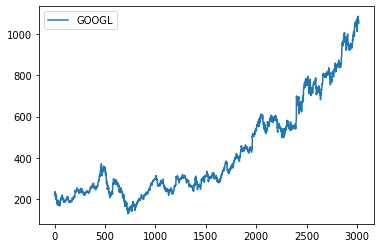

In [4]:
# DataFrame 可视化
def plotDf(df):
    df.plot()
    plt.legend(loc="upper left", ncol=3)
    plt.show()

data.drop(columns="Date", inplace=True)
plotDf(data)

### 1.2 构造 Pytorch 迭代对象

上次作业中，我们直接使用股票价格作为输入数据。但是由于不同公司的股价差别很大，这样的模型不具有泛化能力。在本次作业中，我们使用【日收益率】作为输入的特征。第 t 个 timestep 的日收益率定义为

$$
R_t = \frac{p_{t+1} - p_t}{p_t}
$$

可以忽略日期不连续的问题，把股价视为一个时间序列。具体要求

- 继承 torch.utils.data.Dataset 定义一个可以随机访问和迭代的对象。利用此对象构造训练集、验证集和测试集。

- 构造`Pytorch`中标准的`DataLoader`类。

In [5]:
n_stocks = 1  # 股票数量
K = 25        # 窗口长度

In [6]:
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, data, K):
        self.data = data[1:] / data[:-1]-1
        # self.data=data
        self.K = K

    def __len__(self):
        return len(self.data) - self.K

    def __getitem__(self, idx):
        # return the `idx` - th object (x, y) in the dataset
        return (self.data[idx : idx + K], 
                self.data[idx + K].unsqueeze(0))


def splitData(data, K):
    data = torch.Tensor(data.to_numpy())
    train_data = StockDataset(data[:-500], K)
    test_data = StockDataset(data[-500:], K)

    train_size = int(0.8 * len(train_data))
    valid_size = len(train_data) - train_size
    train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])

    train_iter = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
    valid_iter = torch.utils.data.DataLoader(valid_data, batch_size=64)
    test_iter = torch.utils.data.DataLoader(test_data, batch_size=64)
    return train_iter, valid_iter, test_iter

train_iter, valid_iter, test_iter = splitData(data, K)

### 1.3 定义模型、损失函数和优化器

使用 LSTM 模型预测股价。由于 LSTM 是一个 seq2seq 的模型，而股票价格预测只需要输出一个值，因此我们只采用 LSTM 的最后一个 cell 的输出。 

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

hidden_size = 31
num_layers = 1

In [8]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden, num_layers):
        super(MyModel, self).__init__()
        ### TODO：实现 LSTM 模型
        self.lstm=nn.LSTM(input_size=input_size,hidden_size=hidden,num_layers=num_layers)


        ### TODO：实现全连接作为后处理
        self.fc=nn.Linear(hidden,input_size)


    def forward(self, X):
        ### TODO：实现 forward 部分的计算
        # print(f'X: {X.shape}')
        out,_=self.lstm(X)
        # l=out.shape[1]
        # out=out.permute(1,0,2).reshape(l,-1)
        # print(out.shape)
        out=self.fc(out[-1])
        # out=self.fc(out)
        return out



net = MyModel(n_stocks, hidden_size, num_layers)
net = net.to(device)
print(net)

MyModel(
  (lstm): LSTM(1, 31)
  (fc): Linear(in_features=31, out_features=1, bias=True)
)


关于损失函数，这里我们使用【平均绝对百分比误差（MAPE）】损失函数。该函数的定义如下：

$$
    MAPELoss(pred, label) = \frac{1}{n}\sum_{i}\frac{|pred_i - label_i|}{label_i}
$$

该函数和 MSELoss 的区别主要是：

1. 使用绝对值而不是平方；

2. 使用百分比衡量误差，loss=0%为完美模型，loss>100%表示劣质模型。

MAPE 可以减少不同量级的数据导致的模型误差。股价波动高的公司占据了绝大部分的 MSE，而 MAPE 可以避免这个问题。除此之外，MAPE 还可以直观地给出模型的评价。

In [9]:
def MAPELoss(preds, labels):
    ### TODO：实现 MAPELoss
    preds=preds.squeeze()
    labels=labels.squeeze()
    return (torch.abs(preds-labels)/(torch.abs(labels)+1e-3)).mean()

loss_fn = MAPELoss
# loss_fn=nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-4)

### 1.4 模型训练和测试

训练模型。`evaluate_model`用于评估模型`net`在`data_iter`上的表现，给出平均损失；`train`会在`train_iter`上训练模型`net`，优化器选择`optimizer`，并用`valid_iter`进行验证及early stop。

**请你完善以下代码。**代码仅供参考，觉得不方便的地方，可以直接修改。

In [10]:
from utils import EarlyStop
min_loss=1e10
best_net=None
class mypred():
    def eval(self):
        pass
    def __call__(self,X):
        # print(X.shape)
        return X[-1]
class pred0():
    def eval(self):
        pass
    def __call__(self,X):
        # print(X.shape)
        return torch.zeros_like(X[-1])
def evaluate_model(data_iter, net, loss_fn, device=device):
    ###TODO：实现 evaluate
    net.eval()
    loss_sum,n=0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            X=X.to(device).permute(1,0,2)
            X=X.to(device)
            y=y.to(device)
            pred=net(X)
            # print(pred.shape,y.shape)
            loss=loss_fn(pred,y)
            loss_sum+=loss.item()*y.numel()
            n+=y.numel()
    return loss_sum/n
def train(net, train_iter, valid_iter, loss_fn, optimizer, max_epochs=100, early_stop=None, device=device):
    ### TODO：实现 train
    global min_loss,best_net
    for i in range(max_epochs):
        net.train()
        loss_sum,n=0.0,0
        for X,y in train_iter:
            X=X.to(device).permute(1,0,2)
            y=y.to(device)
            pred=net(X)
            loss=loss_fn(pred,y)
            loss.backward()
            optimizer.step()
            loss_sum+=loss.detach().item()*y.numel()
            n+=y.numel()
        train_loss=loss_sum/n
        valid_loss=evaluate_model(valid_iter,net,loss_fn)
        if valid_loss<min_loss:
            min_loss,best_net=valid_loss,copy.deepcopy(net)
        print(f'epoch: {i} train loss: {train_loss:.6f} valid loss: {valid_loss:.6f}')
        if early_stop is not None:
            if early_stop(valid_loss,net,optimizer):
                break


In [11]:
my_net=mypred()
net_0=pred0()
train(net, train_iter, valid_iter, loss_fn, 
      optimizer, max_epochs=1000, early_stop=EarlyStop(patience=100))

epoch: 0 train loss: 19.656787 valid loss: 16.874064
epoch: 1 train loss: 13.387163 valid loss: 9.915055
epoch: 2 train loss: 6.274548 valid loss: 2.579270
epoch: 3 train loss: 2.214893 valid loss: 4.985416
EarlyStopping counter: 1 out of 100
epoch: 4 train loss: 7.380124 valid loss: 9.639566
EarlyStopping counter: 2 out of 100
epoch: 5 train loss: 10.255197 valid loss: 10.564737
EarlyStopping counter: 3 out of 100
epoch: 6 train loss: 9.783375 valid loss: 8.809295
EarlyStopping counter: 4 out of 100
epoch: 7 train loss: 7.347053 valid loss: 5.691957
EarlyStopping counter: 5 out of 100
epoch: 8 train loss: 4.031494 valid loss: 2.139286
epoch: 9 train loss: 1.323814 valid loss: 1.928227
epoch: 10 train loss: 3.119826 valid loss: 4.488460
EarlyStopping counter: 1 out of 100
epoch: 11 train loss: 5.108703 valid loss: 5.866739
EarlyStopping counter: 2 out of 100
epoch: 12 train loss: 5.912305 valid loss: 6.105055
EarlyStopping counter: 3 out of 100
epoch: 13 train loss: 5.687268 valid loss

In [12]:
print(f"test loss: {evaluate_model(test_iter, best_net, loss_fn):.6f}")
print(f'my loss: {evaluate_model(test_iter, my_net, loss_fn):.6f}')
print(f'0 loss: {evaluate_model(test_iter, net_0, loss_fn):.6f}')
for X,y in test_iter:
    print(best_net(X).squeeze())
    break

test loss: 0.786623
my loss: 1.944604
0 loss: 0.782226
tensor([0.0004, 0.0003, 0.0003, 0.0004, 0.0003, 0.0003, 0.0005, 0.0003, 0.0003,
        0.0009, 0.0001, 0.0006, 0.0004, 0.0006, 0.0003, 0.0003, 0.0005, 0.0003,
        0.0003, 0.0002, 0.0004, 0.0003, 0.0005, 0.0004, 0.0004],
       grad_fn=<SqueezeBackward0>)


思考：如果把LSTM的模型中【只用最后一个 cell】改为【使用全部 cell】，应当怎样处理？模型的效果如何？

我是直接摊平然后全连接。。  
对单个股票的预测并没有显著的效果。。。  
对多个股票的预测结果显著下降。。可能是因为网络参数增加导致训练得更慢了。。

## 2. 多支股票预测

根据市场有效性理论，股票价格是随机游走（Maurice Kendall 1953），通过股价的**自相关性**预测股价几乎是不可能的。但是，股价可能和**其他时间序列**具有相关性。我们可以利用其他时间序列辅助预测。

本作业中我们使用 31 支股票组成一组向量，重复上述实验。

### 2.1 导入文件

注意不同文件中包含的数据条数不同，需要按日期合并。

In [13]:
def loadFiles(dir_path):
    data = []
    for i, file in enumerate(os.listdir(dir_path)):
        data.append(loadOneFile(os.path.join(dir_path, file)))
    
    ### TODO：按【日期（"Date"）】合并不同公司股价的 DataFrame
    for i in range(1,len(data)):
        data[0]=data[0].merge(data[i],how='inner',on='Date')

    return data[0]

df = loadFiles("time-series-data/")
print(df)
df.head()

            Date    MRK     CAT   INTC   MSFT     DIS     UTX     UNH  \
0     2006-01-03  32.75   57.80  25.57  26.84   24.40   56.53   61.73   
1     2006-01-04  33.13   59.27  25.91  26.97   23.99   56.19   61.88   
2     2006-01-05  33.18   59.27  26.27  26.99   24.41   55.98   61.69   
3     2006-01-06  33.12   60.45  26.31  26.91   24.74   56.16   62.90   
4     2006-01-09  33.66   61.55  26.47  26.86   25.00   56.80   61.40   
...          ...    ...     ...    ...    ...     ...     ...     ...   
3013  2017-12-22  56.36  155.75  46.70  85.51  108.67  127.23  220.00   
3014  2017-12-26  56.34  156.44  46.08  85.40  108.12  127.14  219.60   
3015  2017-12-27  56.34  157.52  46.11  85.71  107.64  127.58  220.42   
3016  2017-12-28  56.60  158.42  46.22  85.72  107.77  128.12  222.77   
3017  2017-12-29  56.27  157.58  46.16  85.54  107.51  127.57  220.46   

         AMZN    XOM  ...   CSCO      BA    PFE     JNJ      GS     MMM  \
0       47.58  58.47  ...  17.45   70.44  23.78 

,Date,MRK,CAT,INTC,MSFT,DIS,UTX,UNH,AMZN,XOM,...,CSCO,BA,PFE,JNJ,GS,MMM,MCD,AABA,GE,AXP
0,2006-01-03,32.75,57.80,25.57,26.84,24.40,56.53,61.73,47.58,58.47,...,17.45,70.44,23.78,61.63,128.87,79.11,33.52,40.91,35.37,52.58
1,2006-01-04,33.13,59.27,25.91,26.97,23.99,56.19,61.88,47.25,58.57,...,17.85,71.17,24.55,62.58,127.09,78.71,33.82,40.97,35.32,51.95
2,2006-01-05,33.18,59.27,26.27,26.99,24.41,55.98,61.69,47.65,58.28,...,18.35,70.33,24.58,62.32,127.04,77.99,33.86,41.53,35.23,52.50
3,2006-01-06,33.12,60.45,26.31,26.91,24.74,56.16,62.90,47.87,59.43,...,18.77,69.35,24.85,62.60,128.84,78.63,34.06,43.21,35.47,52.68
4,2006-01-09,33.66,61.55,26.47,26.86,25.00,56.80,61.40,47.08,59.40,...,19.06,68.77,24.85,62.99,130.39,79.02,34.71,43.42,35.38,53.99


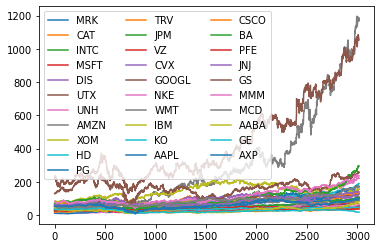

In [14]:
# DataFrame可视化
df.drop(columns="Date", inplace=True)
plotDf(df)

### 2.2 构造 Pytorch 迭代对象

In [15]:
n_stocks = len(df.columns)  # 股票数量
K = 25                      # 窗口长度

In [16]:
train_iter, valid_iter, test_iter = splitData(df, K)

### 2.3 定义模型、损失函数和优化器

In [17]:
net = MyModel(n_stocks, hidden_size, num_layers)
net = net.to(device)
print(net)

MyModel(
  (lstm): LSTM(31, 31)
  (fc): Linear(in_features=31, out_features=31, bias=True)
)


In [18]:
loss_fn = MAPELoss
# loss_fn=nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-4)

### 2.4 模型训练和测试

In [19]:
min_loss=1e10
best_net=None
train(net, train_iter, valid_iter, loss_fn, 
      optimizer, max_epochs=1000, early_stop=EarlyStop(patience=100))

epoch: 0 train loss: 17.298483 valid loss: 16.505287
epoch: 1 train loss: 15.141674 valid loss: 14.300837
epoch: 2 train loss: 12.888863 valid loss: 11.930891
epoch: 3 train loss: 10.522779 valid loss: 9.467514
epoch: 4 train loss: 8.128828 valid loss: 7.128152
epoch: 5 train loss: 6.441792 valid loss: 6.298316
epoch: 6 train loss: 5.977391 valid loss: 5.888119
epoch: 7 train loss: 5.513039 valid loss: 5.217576
epoch: 8 train loss: 4.603680 valid loss: 4.220021
epoch: 9 train loss: 3.832504 valid loss: 3.644696
epoch: 10 train loss: 3.392314 valid loss: 3.168895
epoch: 11 train loss: 2.987743 valid loss: 2.967668
epoch: 12 train loss: 2.924442 valid loss: 2.983768
EarlyStopping counter: 1 out of 100
epoch: 13 train loss: 3.004779 valid loss: 3.170816
EarlyStopping counter: 2 out of 100
epoch: 14 train loss: 3.198945 valid loss: 3.311015
EarlyStopping counter: 3 out of 100
epoch: 15 train loss: 3.182762 valid loss: 3.120789
EarlyStopping counter: 4 out of 100
epoch: 16 train loss: 2.907

In [20]:
print(f"test loss: {evaluate_model(test_iter, best_net, loss_fn):.6f}")
print(f'my loss: {evaluate_model(test_iter, my_net, loss_fn):.6f}')
print(f'0 loss: {evaluate_model(test_iter, net_0, loss_fn):.6f}')
for X,y in test_iter:
    print(best_net(X).squeeze())
    break

test loss: 2.240494
my loss: 1.846762
0 loss: 0.769137
tensor([[-2.6513e-03, -1.8591e-02,  7.3293e-03,  1.0177e-02, -5.4904e-03,
         -2.5115e-03, -4.2102e-03,  2.7751e-02, -6.7913e-03, -7.5626e-04,
         -9.5387e-03, -1.3597e-02,  1.2773e-02, -4.3925e-03,  7.3251e-03,
          1.2903e-02, -3.3183e-03,  7.2858e-03,  1.2967e-02, -2.0351e-02,
         -5.7182e-03,  1.1223e-02, -8.4600e-03,  1.0793e-02,  2.4132e-02,
          2.7004e-03,  2.9361e-03,  3.1068e-03, -1.3035e-02, -5.9744e-03,
         -1.2646e-03],
        [-1.4206e-03, -1.9282e-02,  7.0163e-03,  8.4412e-03, -9.5345e-03,
         -1.5970e-03, -4.1893e-03,  2.6207e-02, -9.7393e-03, -2.0007e-03,
         -7.6945e-03, -1.3091e-02,  1.3073e-02, -3.7963e-03,  7.4590e-03,
          1.0225e-02, -1.1059e-03,  7.1712e-03,  1.3156e-02, -2.1286e-02,
         -3.8560e-03,  1.0688e-02, -6.5314e-03,  1.1093e-02,  2.1825e-02,
          4.2776e-03,  1.8128e-03,  2.4946e-03, -1.5962e-02, -5.1922e-03,
         -2.7534e-03],
        [-6

思考：
- 如果使用股价，而不是日收益率，结果会怎样？使用日收益率还有必要做 normalize 吗？
- 如果使用MSE，而不是MAPE，结果会怎样？
- 如果日收益率定义为

  $$
  R_t = \frac{p_{t+1}}{p_t}
  $$

  你有哪些发现？

+ 经过大量数据的训练，这个模型学会了输出0。。。。。。。。（好像没啥问题\[doge\]）
+ 使用“直接输出前一天的数据”（即 my loss）和“全零的预测值”（即 0 loss）作为基准值
+ 直接使用股价进行预测的话，对单个股票和多个股票的预测影响都非常显著。。（可能是因为学会输出前一天的值要比学会输出0难）
+ 如果日收益率不-1的话。。MAPE会特别小。。因为分母很接近1，然后其他和日收益率没有太大区别
+ 用MSE的话。。因为本来差就<1，然后再平方就更小了。。然后loss就特别特别小。。对单个股票的训练结果并没有太大影响。。但预测多个股票的时候模型很难收敛（大概是因为“股价波动高的公司占据了绝大部分的 MSE”？）  